In [ ]:
import re
import random
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report, accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset
import transformers
from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments, pipeline
from transformers.data.processors.utils import InputFeatures

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [ ]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# **Data**

In [ ]:
# قراءة ملف البيانات
df = pd.read_csv('/content/All_Data_AfterCleaning_Excel.csv')

# عرض شكل البيانات للتأكد من عدد الصفوف والأعمدة
print("Dataset shape:", df.shape)



Dataset shape: (6288, 3)


In [ ]:
# عرض أول خمس صفوف للتأكد من ترتيب الأعمدة
print(df.head())

# معلومات عن البيانات
df.info()



                                                Text   Emotion Dialect
0  بموت ايش هادا الغزل الرخيص بس معليش صادقه والل...   sarcasm       H
1  ياربي معاتيه كل واحد يسوي مصيبه يزغرط يركب حصا...     anger       W
2   \n\n \n \n  حدث لقاء الاكسوالز الياباني  في ت...  surprise       W
3  امانة خير تزكرت لمن غنوها ف الماضي المشؤوم بس ...   sadness       H
4  مع اني مابلعتها بالدراما وكرهتها بس من جد طلعت...   disgust       W
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6288 entries, 0 to 6287
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Text     6288 non-null   object
 1   Emotion  6288 non-null   object
 2   Dialect  6288 non-null   object
dtypes: object(3)
memory usage: 147.5+ KB


In [ ]:
# تحديد أسماء الأعمدة: النص، العاطفة، واللهجة
DATA_COLUMN = "Text"
LABEL_COLUMN_EMOTION = "Emotion"
LABEL_COLUMN_DIALECT = "Dialect"

# عرض أول 10 صفوف للتأكد من المحتوى
print(df.head(n=10))

# عرض آخر 10 صفوف
print(df.tail(n=10))

# عرض توزيع القيم في عمود اللهجات
print("Dialect distribution:\n", df[LABEL_COLUMN_DIALECT].value_counts())

# عرض توزيع القيم في عمود العواطف
print("Emotion distribution:\n", df[LABEL_COLUMN_EMOTION].value_counts())



                                                Text   Emotion Dialect
0  بموت ايش هادا الغزل الرخيص بس معليش صادقه والل...   sarcasm       H
1  ياربي معاتيه كل واحد يسوي مصيبه يزغرط يركب حصا...     anger       W
2   \n\n \n \n  حدث لقاء الاكسوالز الياباني  في ت...  surprise       W
3  امانة خير تزكرت لمن غنوها ف الماضي المشؤوم بس ...   sadness       H
4  مع اني مابلعتها بالدراما وكرهتها بس من جد طلعت...   disgust       W
5   يول ايش ذا الشعر بالله بموت \n \n  \n \n \n  \n    disgust       W
6   \n \n  \n \n \nطريقة الرقص الغريبه هذه بالتأك...  surprise       H
7  راحت هيبة كيونق محد يخاف منو الا تشان  \n \n \...      fear       H
8  من جد قلة ادب و وقاحة اصلا الأدمي راجع تعبان ي...     anger       H
9  امانة اقسم بالله لو انهم ماقالو انو بيك ماكان ...  surprise       H
                                                   Text   Emotion Dialect
6278  ياجحفي جحفاهوجه خائف يصرخ  مريضة\n الله يكفانا...  surprise       S
6279  ياجحفي جحفاه وشذا القصيد الي كنه الحيه لعن وال...  surprise      

In [ ]:

# التحقق من القيم المفقودة بعد الحذف
print(df.isnull().sum())

# تقسيم البيانات إلى تدريب واختبار بنسبة 70% تدريب و 30% اختبار
from sklearn.model_selection import train_test_split

SEED = 42  # عشان النتائج تكون متسقة
train_main, test_main = train_test_split(
    df, test_size=0.3, shuffle=True, random_state=SEED, stratify=df[LABEL_COLUMN_DIALECT]
)


Text       0
Emotion    0
Dialect    0
dtype: int64


In [ ]:
# قائمة بجميع الفئات (العواطف واللهجات) الموجودة في البيانات
label_list_main_dialect = list(df[LABEL_COLUMN_DIALECT].unique())
label_list_main_emotion = list(df[LABEL_COLUMN_EMOTION].unique())

# عرض بعض المعلومات عن البيانات التدريبية
print("Training length: ", len(train_main))
print("Training Dialects distribution:\n", train_main[LABEL_COLUMN_DIALECT].value_counts(), '\n')
print("Training Emotions distribution:\n", train_main[LABEL_COLUMN_EMOTION].value_counts(), '\n')

Training length:  4401
Training Dialects distribution:
 Dialect
H    1467
W    1467
S    1467
Name: count, dtype: int64 

Training Emotions distribution:
 Emotion
anger        581
disgust      559
Neutral      555
sadness      552
fear         551
happiness    538
surprise     537
sarcasm      528
Name: count, dtype: int64 



In [ ]:
# عرض بعض المعلومات عن بيانات الاختبار
print("Testing length: ", len(test_main))
print("Testing Dialects distribution:\n", test_main[LABEL_COLUMN_DIALECT].value_counts())
print("Testing Emotions distribution:\n", test_main[LABEL_COLUMN_EMOTION].value_counts())


Testing length:  1887
Testing Dialects distribution:
 Dialect
H    629
W    629
S    629
Name: count, dtype: int64
Testing Emotions distribution:
 Emotion
sarcasm      258
surprise     249
happiness    248
fear         235
sadness      234
Neutral      231
disgust      227
anger        205
Name: count, dtype: int64


In [ ]:
# عرض قائمة الفئات (اللهجات والعواطف) الموجودة في الملف
print("Unique Dialects in dataset:", label_list_main_dialect)
print("Unique Emotions in dataset:", label_list_main_emotion)

Unique Dialects in dataset: ['H', 'W', 'S']
Unique Emotions in dataset: ['sarcasm', 'anger', 'surprise', 'sadness', 'disgust', 'fear', 'Neutral', 'happiness']


# **Clean Data**

In [ ]:
# تنظيف وتحضير البيانات للـ CustomDataset
class CustomDataset:

    def __init__(self, name: str, train: pd.DataFrame, test: pd.DataFrame, label_list_dialect: list[str], label_list_emotion: list[str]):
        self.name = name
        self.train = train
        self.test = test
        self.label_list_dialect = label_list_dialect
        self.label_list_emotion = label_list_emotion

# إنشاء كائن من CustomDataset، مع تحديد الفئات الخاصة بكل من اللهجات والعواطف
data_main = CustomDataset(
    name="Project-Dataset",
    train=train_main,
    test=test_main,
    label_list_dialect=label_list_main_dialect,
    label_list_emotion=label_list_main_emotion
)


In [ ]:
# عرض اسم الكائن
print("Dataset Name:", data_main.name)

# عرض قائمة الفئات الخاصة باللهجات
print("Dialect Labels:", data_main.label_list_dialect)

# عرض قائمة الفئات الخاصة بالعواطف
print("Emotion Labels:", data_main.label_list_emotion)



Dataset Name: Project-Dataset
Dialect Labels: ['H', 'W', 'S']
Emotion Labels: ['sarcasm', 'anger', 'surprise', 'sadness', 'disgust', 'fear', 'Neutral', 'happiness']


In [ ]:
# عرض عدد الفئات لكل من اللهجات والعواطف
print("Number of Dialect Labels:", len(data_main.label_list_dialect))
print("Number of Emotion Labels:", len(data_main.label_list_emotion))



Number of Dialect Labels: 3
Number of Emotion Labels: 8


In [ ]:
# البحث عن القيم المفقودة في عمود النصوص ضمن البيانات التدريبية
nan_in_train_text = data_main.train[data_main.train[DATA_COLUMN].isnull()]
print("Missing values in training data (Text column):\n", nan_in_train_text)

Missing values in training data (Text column):
 Empty DataFrame
Columns: [Text, Emotion, Dialect]
Index: []


In [ ]:
# البحث عن القيم المفقودة في عمود النصوص ضمن بيانات الاختبار
nan_in_test_text = data_main.test[data_main.test[DATA_COLUMN].isnull()]
print("Missing values in testing data (Text column):\n", nan_in_test_text)

Missing values in testing data (Text column):
 Empty DataFrame
Columns: [Text, Emotion, Dialect]
Index: []


In [ ]:
# عرض أول 10 صفوف من البيانات التدريبية للتحقق
print("First 10 rows of training data:\n", data_main.train.head(n=10))

First 10 rows of training data:
                                                    Text   Emotion Dialect
167                                    كولد بلااي جوو\n   sarcasm       H
5000  الاقارب عقارب خاصة اذا كان فيه مشاكل سابقة واح...     anger       W
3610  احليلك يالريم اشفق ع اللي مثلك مخصصه حساب كامل...     anger       W
5054  اسطورتك الكرويه الصغر رجال عوود كان لاعب بنادي...     anger       W
4341  جايه نعسانه والدكتوره تقول غيري مكانك انتبهي ق...      fear       W
5280   تجربة النوم الروسية أكثر تجربة مرعبة أجريت البشر      fear       H
5556                 هذا الانسان وصل لاخر مراحل القذارة   disgust       W
3818  هذا من كرم الضيافه بقعي تصوعس المقلط دايم يكون...     anger       S
5015  فواحش وفساد المستشفيات لو الله يخلصنا المستطوع...     anger       W
2999  كنت  متأكده ان هاليوم سيء وخلاص يأست بس ربي فأ...  surprise       W


##**Input Preproccessing**

In [ ]:
import re
import pandas as pd

class TextProcessor:
    def _init_(self):
        self.arabic_diacritics_pattern = re.compile("[\u064B-\u065F\u0670\u0615-\u061A]")
        self.flag_mapping = {
        '🇦🇫': 'أفغانستان',
        '🇦🇱': 'ألبانيا',
        '🇩🇿': 'الجزائر',
        '🇦🇩': 'أندورا',
        '🇦🇴': 'أنغولا',
        '🇦🇬': 'أنتيغوا وبربودا',
        '🇦🇷': 'الأرجنتين',
        '🇦🇲': 'أرمينيا',
        '🇦🇼': 'أروبا',
        '🇦🇺': 'أستراليا',
        '🇦🇹': 'النمسا',
        '🇦🇿': 'أذربيجان',
        '🇧🇸': 'الباهاما',
        '🇧🇭': 'البحرين',
        '🇧🇩': 'بنغلاديش',
        '🇧🇧': 'بربادوس',
        '🇧🇾': 'بيلاروسيا',
        '🇧🇪': 'بلجيكا',
        '🇧🇿': 'بليز',
        '🇧🇯': 'بنين',
        '🇧🇹': 'بوتان',
        '🇧🇴': 'بوليفيا',
        '🇧🇦': 'البوسنة والهرسك',
        '🇧🇼': 'بوتسوانا',
        '🇧🇷': 'البرازيل',
        '🇧🇳': 'بروناي',
        '🇧🇬': 'بلغاريا',
        '🇧🇫': 'بوركينا فاسو',
        '🇧🇮': 'بوروندي',
        '🇰🇭': 'كمبوديا',
        '🇨🇲': 'الكاميرون',
        '🇨🇦': 'كندا',
        '🇨🇻': 'الرأس الأخضر',
        '🇰🇾': 'جزر كايمان',
        '🇨🇫': 'جمهورية أفريقيا الوسطى',
        '🇹🇩': 'تشاد',
        '🇨🇱': 'تشيلي',
        '🇨🇳': 'الصين',
        '🇨🇴': 'كولومبيا',
        '🇰🇲': 'جزر القمر',
        '🇨🇬': 'الكونغو - برازافيل',
        '🇨🇩': 'جمهورية الكونغو الديمقراطية',
        '🇨🇰': 'جزر كوك',
        '🇨🇷': 'كوستاريكا',
        '🇭🇷': 'كرواتيا',
        '🇨🇺': 'كوبا',
        '🇨🇾': 'قبرص',
        '🇨🇿': 'التشيك',
        '🇩🇰': 'الدانمارك',
        '🇩🇯': 'جيبوتي',
        '🇩🇲': 'دومينيكا',
        '🇩🇴': 'جمهورية الدومينيكان',
        '🇪🇨': 'الإكوادور',
        '🇪🇬': 'مصر',
        '🇸🇻': 'السلفادور',
        '🇬🇶': 'غينيا الاستوائية',
        '🇪🇷': 'إريتريا',
        '🇪🇪': 'إستونيا',
        '🇪🇹': 'إثيوبيا',
        '🇫🇯': 'فيجي',
        '🇫🇮': 'فنلندا',
        '🇫🇷': 'فرنسا',
        '🇬🇦': 'الغابون',
        '🇬🇲': 'غامبيا',
        '🇬🇪': 'جورجيا',
        '🇩🇪': 'ألمانيا',
        '🇬🇭': 'غانا',
        '🇬🇷': 'اليونان',
        '🇬🇩': 'غرينادا',
        '🇬🇹': 'غواتيمالا',
        '🇬🇳': 'غينيا',
        '🇬🇼': 'غينيا بيساو',
        '🇬🇾': 'غيانا',
        '🇭🇹': 'هايتي',
        '🇭🇳': 'هندوراس',
        '🇭🇺': 'المجر',
        '🇮🇸': 'أيسلندا',
        '🇮🇳': 'الهند',
        '🇮🇩': 'إندونيسيا',
        '🇮🇷': 'إيران',
        '🇮🇶': 'العراق',
        '🇮🇪': 'أيرلندا',
        '🇮🇱': 'إسرائيل',
        '🇮🇹': 'إيطاليا',
        '🇯🇲': 'جامايكا',
        '🇯🇵': 'اليابان',
        '🇯🇴': 'الأردن',
        '🇰🇿': 'كازاخستان',
        '🇰🇪': 'كينيا',
        '🇰🇮': 'كيريباتي',
        '🇽🇰': 'كوسوفو',
        '🇰🇼': 'الكويت',
        '🇰🇬': 'قيرغيزستان',
        '🇱🇦': 'لاوس',
        '🇱🇻': 'لاتفيا',
        '🇱🇧': 'لبنان',
        '🇱🇸': 'ليسوتو',
        '🇱🇷': 'ليبريا',
        '🇱🇾': 'ليبيا',
        '🇱🇮': 'ليختنشتاين',
        '🇱🇹': 'ليتوانيا',
        '🇱🇺': 'لوكسمبورغ',
        '🇲🇰': 'مقدونيا الشمالية',
        '🇲🇬': 'مدغشقر',
        '🇲🇼': 'مالاوي',
        '🇲🇾': 'ماليزيا',
        '🇲🇻': 'جزر المالديف',
        '🇲🇱': 'مالي',
        '🇲🇹': 'مالطا',
        '🇲🇭': 'جزر مارشال',
        '🇲🇷': 'موريتانيا',
        '🇲🇺': 'موريشيوس',
        '🇲🇽': 'المكسيك',
        '🇫🇲': 'ميكرونيزيا',
        '🇲🇩': 'مولدوفا',
        '🇲🇨': 'موناكو',
        '🇲🇳': 'منغوليا',
        '🇲🇪': 'الجبل الأسود',
        '🇲🇦': 'المغرب',
        '🇲🇿': 'موزمبيق',
        '🇲🇲': 'ميانمار',
        '🇳🇦': 'ناميبيا',
        '🇳🇷': 'ناورو',
        '🇳🇵': 'نيبال',
        '🇳🇱': 'هولندا',
        '🇳🇿': 'نيوزيلندا',
        '🇳🇮': 'نيكاراجوا',
        '🇳🇪': 'النيجر',
        '🇳🇬': 'نيجيريا',
        '🇰🇵': 'كوريا الشمالية',
        '🇳🇴': 'النرويج',
        '🇴🇴': 'جزر أورسي',
        '🇵🇰': 'باكستان',
        '🇵🇼': 'بالاو',
        '🇵🇸': 'فلسطين',
        '🇵🇦': 'بنما',
        '🇵🇬': 'بابوا غينيا الجديدة',
        '🇵🇾': 'باراغواي',
        '🇵🇪': 'بيرو',
        '🇵🇭': 'الفلبين',
        '🇵🇱': 'بولندا',
        '🇵🇹': 'البرتغال',
        '🇶🇦': 'قطر',
        '🇷🇴': 'رومانيا',
        '🇷🇺': 'روسيا',
        '🇷🇼': 'رواندا',
        '🇰🇳': 'سانت كيتس ونيفيس',
        '🇱🇨': 'سانت لوسيا',
        '🇻🇨': 'سانت فينسنت والغرينادين',
        '🇼🇸': 'ساموا',
        '🇸🇲': 'سان مارينو',
        '🇸🇹': 'ساو تومي وبرينسيبي',
        '🇸🇦': 'السعودية',
        '🇸🇳': 'السنغال',
        '🇷🇸': 'صربيا',
        '🇸🇨': 'سيشيل',
        '🇸🇱': 'سيراليون',
        '🇸🇬': 'سنغافورة',
        '🇸🇰': 'سلوفاكيا',
        '🇸🇮': 'سلوفينيا',
        '🇸🇧': 'جزر سليمان',
        '🇸🇴': 'الصومال',
        '🇿🇦': 'جنوب أفريقيا',
        '🇰🇷': 'كوريا الجنوبية',
        '🇸🇸': 'جنوب السودان',
        '🇪🇸': 'إسبانيا',
        '🇱🇰': 'سريلانكا',
        '🇸🇩': 'السودان',
        '🇸🇷': 'سورينام',
        '🇸🇿': 'سوازيلاند',
        '🇸🇪': 'السويد',
        '🇨🇭': 'سويسرا',
        '🇸🇾': 'سوريا',
        '🇹🇼': 'تايوان',
        '🇹🇯': 'طاجيكستان',
        '🇹🇿': 'تنزانيا',
        '🇹🇭': 'تايلاند',
        '🇹🇱': 'تيمور الشرقية',
        '🇹🇬': 'توغو',
        '🇹🇴': 'تونغا',
        '🇹🇹': 'ترينيداد وتوباغو',
        '🇹🇳': 'تونس',
        '🇹🇷': 'تركيا',
        '🇹🇲': 'تركمانستان',
        '🇹🇻': 'توفالو',
        '🇺🇬': 'أوغندا',
        '🇺🇦': 'أوكرانيا',
        '🇦🇪': 'الإمارات العربية المتحدة',
        '🇬🇧': 'المملكة المتحدة',
        '🇺🇸': 'الولايات المتحدة',
        '🇺🇾': 'أوروغواي',
        '🇺🇿': 'أوزبكستان',
        '🇻🇺': 'فانواتو',
        '🇻🇦': 'الفاتيكان',
        '🇻🇪': 'فنزويلا',
        '🇻🇳': 'فيتنام',
        '🇾🇪': 'اليمن',
        '🇿🇲': 'زامبيا',
        '🇿🇼': 'زيمبابوي',
    }
        self.emoji_dict = None

    def remove_arabic_diacritics(self, text):
        return self.arabic_diacritics_pattern.sub('', text)

    def remove_punc_characters(self, text):
        english_pattern = re.compile(r'[#@&%$!\(\)\{\}[\]:;.,،<>?؟´''""\"''"""\[\]=+/\\|''°~^*_-]')
        cleaned_text = re.sub(english_pattern, ' ', str(text))
        return cleaned_text

    def load_emoji_meanings(self):
      emoji_data = pd.read_csv("/content/emoji lexicon.csv", encoding='utf-8')
      self.emoji_dict = dict(zip(emoji_data['emoji'], emoji_data['Meaning']))

    def translate_emojis(self, text):
        if self.emoji_dict is None:
            raise ValueError("Emoji meanings have not been loaded. Call 'load_emoji_meanings' method first.")

        translated_text = ""
        for char in text:
            if char in self.emoji_dict:
                translated_text += self.emoji_dict[char] + " "
            else:
                translated_text += char
        return translated_text

    def replace_flags(self, text):
        for flag, country in self.flag_mapping.items():
            text = text.replace(flag, f"علم {country}")
        return text

    def remove_non_arabic_characters(self, text):

        arabic_pattern = re.compile(r'[^\u0600-\u06FF\s]+')
        cleaned_text = re.sub(arabic_pattern, '', text)
        return cleaned_text

    def remove_duplicate_characters(self, text):
        cleaned_text = re.sub(r'(.)\1{2,}', r'\1', text)
        return cleaned_text

    def preprocess_text(self, texts):
        if self.emoji_dict is None:
            self.load_emoji_meanings()

        processed_texts = []
        for text in texts:
            # Remove Arabic diacritics
            text = self.remove_arabic_diacritics(text)
            # Removing Punctuations
            text = self.remove_punc_characters(text)
            # Translate emoji
            text = self.translate_emojis(text)
            # Replace flag
            text = self.replace_flags(text)
            # Remove no Arabic characters
            text = self.remove_non_arabic_characters(text)
            # Remove duplicate characters
            text = self.remove_duplicate_characters(text)
            processed_texts.append(text)

        return processed_texts

##**Validating The input text and the calculate the percentage**


In [ ]:
def validate_and_process_texts(texts):
    removedTexts = []
    validtexts = []
    if len(texts) > 1:
        for index, text in enumerate(texts):
            if not contains_arabic(text):
                print(f"Text {index + 1} is not valid: {text}")
                removedTexts.append(index)
            else:
                validtexts.append(text)
        return validtexts, removedTexts
    else:
        if not contains_arabic(texts):
            print("Text is not valid.")
            texts = []
            return texts, removedTexts
        return texts, removedTexts

def contains_arabic(text):
    return any('\u0600' <= ch <= '\u06FF' or '\u0750' <= ch <= '\u077F' or '\u08A0' <= ch <= '\u08FF' for ch in text)



In [ ]:
import matplotlib.pyplot as plt

def percentage(result):
  NumberResult = len(result)
  HAngerCount, HSadCount, HSurprisCount, HNeutralCount, HFearCount, HDisgustCount, HSarcasmCount, HhappyCount = 0, 0, 0, 0, 0, 0, 0, 0
  SAngerCount, SSadCount, SSurprisCount, SNeutralCount, SFearCount, SDisgustCount, SSarcasmCount, ShappyCount = 0, 0, 0, 0, 0, 0, 0, 0
  WAngerCount, WSadCount, WSurprisCount, WNeutralCount, WFearCount, WDisgustCount, WSarcasmCount, WhappyCount = 0, 0, 0, 0, 0, 0, 0, 0
  AngerCount, SadCount, SurprisCount, NeutralCount, FearCount, DisgustCount, SarcasmCount, happyCount = 0, 0, 0, 0, 0, 0, 0, 0
  HCount,WCount,SCount=0, 0, 0
  counter=0

  for i in range(NumberResult):
    if result[i][1] == "H":
      HCount+=1
    elif result[i][1] == "W":
      WCount+=1
    elif result[i][1] == "S":
      SCount+=1

  for i in range(NumberResult):
    if result[i][0] == "surprise":
      SurprisCount+=1
    elif result[i][0] == "happiness":
      happyCount+=1
    elif result[i][0] == "anger":
      AngerCount+=1
    elif result[i][0] == "sadness":
      SadCount+=1
    elif result[i][0] == "Neutral":
      NeutralCount+=1
    elif result[i][0] == "fear":
      FearCount+=1
    elif result[i][0] == "disgust":
      DisgustCount+=1
    elif result[i][0] == "sarcasm":
      SarcasmCount+=1

  for i in range(NumberResult):
    if result[i][0] == "surprise" and result[i][1] == "H":
      HSurprisCount+=1
    elif result[i][0] == "happiness" and result[i][1] == "H":
      happyCount+=1
    elif result[i][0] == "anger" and result[i][1] == "H":
      HAngerCount+=1
    elif result[i][0] == "sadness" and result[i][1] == "H":
      HSadCount+=1
    elif result[i][0] == "Neutral" and result[i][1] == "H":
      HNeutralCount+=1
    elif result[i][0] == "fear" and result[i][1] == "H":
      HFearCount+=1
    elif result[i][0] == "disgust" and result[i][1] == "H":
      HDisgustCount+=1
    elif result[i][0] == "sarcasm" and result[i][1] == "H":
      HSarcasmCount+=1

    elif result[i][0] == "surprise" and result[i][1] == "S":
      SSurprisCount+=1
    elif result[i][0] == "happiness" and result[i][1] == "S":
      ShappyCount+=1
    elif result[i][0] == "anger" and result[i][1] == "S":
      SAngerCount+=1
    elif result[i][0] == "sadness" and result[i][1] == "S":
      SSadCount+=1
    elif result[i][0] == "Neutral" and result[i][1] == "S":
      SNeutralCount+=1
    elif result[i][0] == "fear" and result[i][1] == "S":
      SFearCount+=1
    elif result[i][0] == "disgust" and result[i][1] == "S":
      SDisgustCount+=1
    elif result[i][0] == "sarcasm" and result[i][1] == "S":
      SSarcasmCount+=1

    elif result[i][0] == "surprise" and result[i][1] == "W":
      WSurprisCount+=1
    elif result[i][0] == "happiness" and result[i][1] == "W":
      WhappyCount+=1
    elif result[i][0] == "anger" and result[i][1] == "W":
      WAngerCount+=1
    elif result[i][0] == "sadness" and result[i][1] == "W":
      WSadCount+=1
    elif result[i][0] == "Neutral" and result[i][1] == "W":
      WNeutralCount+=1
    elif result[i][0] == "fear" and result[i][1] == "W":
      WFearCount+=1
    elif result[i][0] == "disgust" and result[i][1] == "W":
      WDisgustCount+=1
    elif result[i][0] == "sarcasm" and result[i][1] == "W":
      WSarcasmCount+=1

  ##This will be showed in page: result.html in the first section
  print("happiness: ", happyCount)
  print("anger: ", AngerCount)
  print("sadness: ", SadCount)
  print("Neutral: ", NeutralCount)
  print("fear: ", FearCount)
  print("disgust: ", DisgustCount)
  print("sarcasm: ", SarcasmCount)
  print("surprise: ", SurprisCount)
  print("Hejazi: ", HCount)
  print("White: ", WCount)
  print("South: ", SCount)


  #computing the percentage for the Dialects
  HCount2 = (HCount/NumberResult)*100
  WCount2 = (WCount/NumberResult)*100
  SCount2 = (SCount/NumberResult)*100

  #computing the percentage for the emotions
  SurprisCount = (SurprisCount / NumberResult) * 100
  happyCount = (happyCount / NumberResult) * 100
  AngerCount = (AngerCount / NumberResult) * 100
  SadCount = (SadCount / NumberResult) * 100
  NeutralCount = (NeutralCount / NumberResult) * 100
  FearCount = (FearCount / NumberResult) * 100
  DisgustCount = (DisgustCount / NumberResult) * 100
  SarcasmCount = (SarcasmCount / NumberResult) * 100

  if SCount != 0:
    #computing the percentage for the emotions in South dialect
    SSurprisCount = (SSurprisCount / SCount) * 100
    ShappyCount = (ShappyCount / SCount) * 100
    SAngerCount = (SAngerCount / SCount) * 100
    SSadCount = (SSadCount / SCount) * 100
    SNeutralCount = (SNeutralCount / SCount) * 100
    SFearCount = (SFearCount / SCount) * 100
    SDisgustCount = (SDisgustCount / SCount) * 100
    SSarcasmCount = (SSarcasmCount / SCount) * 100

    ## South pie Chart ##This will be showed in page: result.html in the third section
    labels = ['anger', 'Neutral', 'sadness', 'fear', 'happiness', 'disgust', 'sarcasm', 'surprise']
    sizes = [SAngerCount, SNeutralCount, SSadCount, SFearCount, ShappyCount, SDisgustCount, SSarcasmCount, SSurprisCount]
    explode = (0.2, 0, 0, 0, 0, 0, 0, 0)
    fig = plt.figure(figsize=(10, 5))
    percent_labels = [f'{label} - {size:.1f}%' for label, size in zip(labels, sizes)]
    colors = plt.cm.Blues(np.linspace(0.2, 1, len(labels)))
    plt.pie(sizes, explode=explode, labels=None, startangle=140, colors=colors)
    plt.axis('equal')
    plt.title("Emotions in South Dialect")
    plt.legend(percent_labels, title="Dialects:", loc='center right')
    plt.show

  else:
    print("No South Dialect")
    # in the window you should make the pie chart in one color and print a text on the pie chart that says:
    #النصوص التي أدخلتها لا تحتوي على هذه اللهجة

  if HCount != 0:
    #computing the percentage for the emotions in Hejazi dialect
    HSurprisCount = (HSurprisCount / HCount) * 100
    HhappyCount = (HhappyCount / HCount) * 100
    HAngerCount = (HAngerCount / HCount) * 100
    HSadCount = (HSadCount / HCount) * 100
    HNeutralCount = (HNeutralCount / HCount) * 100
    HFearCount = (HFearCount / HCount) * 100
    HDisgustCount = (HDisgustCount / HCount) * 100
    HSarcasmCount = (HSarcasmCount / HCount) * 100

    ## Hejazi pie Chart ##This will be showed in page: result.html in the third section
    labels = ['anger', 'Neutral', 'sadness', 'fear', 'happiness', 'disgust', 'sarcasm', 'surprise']
    sizes = [HAngerCount, HNeutralCount, HSadCount, HFearCount, HhappyCount, HDisgustCount, HSarcasmCount, HSurprisCount]
    explode = (0.2, 0, 0, 0, 0, 0, 0, 0)
    fig = plt.figure(figsize=(10, 5))
    percent_labels = [f'{label} - {size:.1f}%' for label, size in zip(labels, sizes)]
    colors = plt.cm.Blues(np.linspace(0.2, 1, len(labels)))
    plt.pie(sizes, explode=explode, labels=None, startangle=140, colors=colors)
    plt.axis('equal')
    plt.title("Emotions in Hejazi Dialect")
    plt.legend(percent_labels, title="Dialects:", loc='center right')
    plt.show

  else:
    print("No Hejazi Dialect")
    # in the window you should make the pie chart in one color and print a text on the pie chart that says:
    #النصوص التي أدخلتها لا تحتوي على هذه اللهجة


  if WCount != 0:
    #computing the percentage for the emotions in White dialect
    WSurprisCount = (WSurprisCount / WCount) * 100
    WhappyCount = (WhappyCount / WCount) * 100
    WAngerCount = (WAngerCount / WCount) * 100
    WSadCount = (WSadCount / WCount) * 100
    WNeutralCount = (WNeutralCount / WCount) * 100
    WFearCount = (WFearCount / WCount) * 100
    WDisgustCount = (WDisgustCount / WCount) * 100
    WSarcasmCount = (WSarcasmCount / WCount) * 100

    ## White pie Chart ##This will be showed in page: result.html in the third section
    labels = ['anger', 'Neutral', 'sadness', 'fear', 'happiness', 'disgust', 'sarcasm', 'surprise']
    sizes = [WAngerCount, WNeutralCount, WSadCount, WFearCount, WhappyCount, WDisgustCount, WSarcasmCount, WSurprisCount]
    explode = (0.2, 0, 0, 0, 0, 0, 0, 0)
    fig = plt.figure(figsize=(10, 5))
    percent_labels = [f'{label} - {size:.1f}%' for label, size in zip(labels, sizes)]
    # Define custom blue colormap
    colors = plt.cm.Blues(np.linspace(0.2, 1, len(labels)))
    plt.pie(sizes, explode=explode, labels=None, startangle=140, colors=colors)
    plt.axis('equal')
    plt.title("Emotions in White Dialect")
    plt.legend(percent_labels, title="Dialects:", loc='center right')
    plt.show()

  else:
    print("No White Dialect")
    # in the window it should make the pie chart in one color and print a text on the pie chart that says:
    #النصوص التي أدخلتها لا تحتوي على هذه اللهجة


  #Dialect pie chart ##This will be showed in page: result.html in the second section
  labels = ['Hejazi','White','South']
  sizes = [HCount2, WCount2, SCount2]  # percentages
  #explode = (0.2, 0.3, 0.3)  # explode 1st slice
  explode = (0.2,0,0)
  fig = plt.figure(figsize=(10, 5))
  percent_labels = [f'{label} - {size:.1f}%' for label, size in zip(labels, sizes)]
  plt.pie(sizes, explode=explode, labels=None, startangle=140)
  plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
  plt.title("Dialects")
  plt.legend(percent_labels,title = "Dialects :",loc='center right')
  plt.show()




  #Emotions pie chart ##This will be showed in page: result.html in the second section
  labels = ['anger','Neutral','sadness','fear','happiness','disgust','sarcasm','suprise']
  sizes = [AngerCount, NeutralCount, SadCount, FearCount,happyCount,DisgustCount,SarcasmCount,SurprisCount]  # percentages
  #explode = (0.2, 0.3, 0.3, 0.3,0.3,0.3,0.3,0.2)  # explode 1st slice
  explode = (0.2,0,0,0,0,0,0,0)
  fig = plt.figure(figsize=(10, 5))
  percent_labels = [f'{label} - {size:.1f}%' for label, size in zip(labels, sizes)]
  plt.pie(sizes, explode=explode, labels=None, startangle=140)
  plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
  plt.legend(percent_labels,title = "Emotions :",loc='center right')
  plt.show()

In [ ]:
import csv

def input_text(egy):
    OldLength = len(egy)
    texts, removedTexts = validate_and_process_texts(egy)
    processor = TextProcessor()

    if len(texts) == 0:
      print("Try another text please. The text you entered is non-arabic")
    elif len(texts) == 1 and (OldLength == 1 or OldLength>1):
      processed_text = processor.preprocess_text(texts)
      results = predict(processed_text)

      #Here The result will be showed in page: first.html
      for i in len(results):
        print(texts[i], ": ",results[i][0], results[i][1])


    elif len(texts) < OldLength and OldLength > 1:
      print("Note: there are some texts that are invalid so they were not predicted.")
      processed_text = processor.preprocess_text(texts)
      results = predict(processed_text)
      #Here the result will be showed in page: result.html
      percentage(results)

    elif len(texts) == OldLength and OldLength > 1:
      processed_text = processor.preprocess_text(texts)
      results = predict(processed_text)
      #Here the result will be showed in page: result.html
      percentage(results)

## Tokenizing the Dataset and helper functions


In [ ]:
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import Dataset

# تعريف أسماء الأعمدة
DATA_COLUMN = 'Text'
LABEL_COLUMN_EMOTION = 'Emotion'
LABEL_COLUMN_DIALECT = 'Dialect'

# نموذج اللهجات
model_name_dialect = 'faisalq/SaudiBERT'
tokenizer_dialect = AutoTokenizer.from_pretrained(model_name_dialect)

max_len_train_dialect = max(len(tokenizer_dialect.tokenize(sentence)) for sentence in data_main.train[DATA_COLUMN].to_list())
max_len_test_dialect = max(len(tokenizer_dialect.tokenize(sentence)) for sentence in data_main.test[DATA_COLUMN].to_list())

max_len_dialect = max(max_len_train_dialect, max_len_test_dialect)

class ClassificationDatasetDialect(Dataset):
    def __init__(self, text: list[str], target: list[str], model_name: str, max_len: int, label_map: dict[str, int]):
        super().__init__()
        self.text = text
        self.target = target
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.max_len = max_len
        self.label_map = label_map

    def __len__(self):
        return len(self.text)

    def __getitem__(self, item):
        text = str(self.text[item])
        inputs = self.tokenizer(
            text,
            max_length=self.max_len,
            padding='max_length',
            truncation=True
        )
        return InputFeatures(**inputs, label=self.label_map[self.target[item]])

# استخدام القيم الفريدة لتحديد الـ label_map
label_list_dialect = list(data_main.train[LABEL_COLUMN_DIALECT].unique())
label_map_dialect = {v: index for index, v in enumerate(label_list_dialect)}

train_dataset_dialect = ClassificationDatasetDialect(
    data_main.train[DATA_COLUMN].to_list(),
    data_main.train[LABEL_COLUMN_DIALECT].to_list(),
    model_name_dialect,
    max_len_dialect,
    label_map_dialect
)
test_dataset_dialect = ClassificationDatasetDialect(
    data_main.test[DATA_COLUMN].to_list(),
    data_main.test[LABEL_COLUMN_DIALECT].to_list(),
    model_name_dialect,
    max_len_dialect,
    label_map_dialect
)



In [ ]:
# نموذج المشاعر
model_name_emotion = 'UBC-NLP/MARBERTv2'
tokenizer_emotion = AutoTokenizer.from_pretrained(model_name_emotion)

max_len_train_emotion = max(len(tokenizer_emotion.tokenize(sentence)) for sentence in data_main.train[DATA_COLUMN].to_list())
max_len_test_emotion = max(len(tokenizer_emotion.tokenize(sentence)) for sentence in data_main.test[DATA_COLUMN].to_list())

max_len_emotion = max(max_len_train_emotion, max_len_test_emotion)

class ClassificationDatasetEmotion(Dataset):
    def __init__(self, text: list[str], target: list[str], model_name: str, max_len: int, label_map: dict[str, int]):
        super().__init__()
        self.text = text
        self.target = target
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.max_len = max_len
        self.label_map = label_map

    def __len__(self):
        return len(self.text)

    def __getitem__(self, item):
        text = str(self.text[item])
        inputs = self.tokenizer(
            text,
            max_length=self.max_len,
            padding='max_length',
            truncation=True
        )
        return InputFeatures(**inputs, label=self.label_map[self.target[item]])

# استخدام القيم الفريدة لتحديد الـ label_map للمشاعر
label_list_emotion = list(data_main.train[LABEL_COLUMN_EMOTION].unique())
label_map_emotion = {v: index for index, v in enumerate(label_list_emotion)}

train_dataset_emotion = ClassificationDatasetEmotion(
    data_main.train[DATA_COLUMN].to_list(),
    data_main.train[LABEL_COLUMN_EMOTION].to_list(),
    model_name_emotion,
    max_len_emotion,
    label_map_emotion
)
test_dataset_emotion = ClassificationDatasetEmotion(
    data_main.test[DATA_COLUMN].to_list(),
    data_main.test[LABEL_COLUMN_EMOTION].to_list(),
    model_name_emotion,
    max_len_emotion,
    label_map_emotion
)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
# دالة تهيئة النماذج
def model_init_dialect():
    model = AutoModelForSequenceClassification.from_pretrained(model_name_dialect, return_dict=True, num_labels=len(label_map_dialect))
    return model

def model_init_emotion():
    return AutoModelForSequenceClassification.from_pretrained(model_name_emotion, return_dict=True, num_labels=len(label_map_emotion))

## Begin Regular Training for Dialect Model

In [ ]:
print(f"عدد بيانات الاختبار للهجات: {len(test_dataset_dialect)}")


عدد بيانات الاختبار للهجات: 1887


In [ ]:
print("البيانات الفريدة للهجات:", label_list_dialect)


البيانات الفريدة للهجات: ['H', 'W', 'S']


In [ ]:
## Begin Regular Training for Dialect Model

from sklearn.metrics import classification_report

from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score, accuracy_score

def compute_metrics_dialect(p):
    preds = np.argmax(p.predictions, axis=1)
    assert len(preds) == len(p.label_ids)

    print(classification_report(p.label_ids, preds))

    macro_f1 = f1_score(p.label_ids, preds, average='macro')
    macro_precision = precision_score(p.label_ids, preds, average='macro')
    macro_recall = recall_score(p.label_ids, preds, average='macro')
    accuracy = accuracy_score(p.label_ids, preds)

    return {
        'macro_f1': macro_f1,
        'macro_precision': macro_precision,
        'macro_recall': macro_recall,
        'accuracy': accuracy
    }


# إعدادات التدريب لنموذج اللهجات
training_args_dialect = TrainingArguments(
    output_dir="train_dialect",
    logging_dir="logs_dialect",
    evaluation_strategy="epoch",
    per_device_train_batch_size=22,
    per_device_eval_batch_size=22,
    gradient_accumulation_steps=1,
    num_train_epochs=10,
    learning_rate=3e-5,
    warmup_ratio=0.1,
    weight_decay=0.01,
    adam_beta1=0.9,
    adam_beta2=0.999,
    adam_epsilon=1e-8,
    fp16=True,
    save_strategy="epoch",
    save_total_limit=3,
    load_best_model_at_end=True,
    metric_for_best_model="macro_f1",
    greater_is_better=True
)

trainer_dialect = Trainer(
    model=model_init_dialect(),
    args=training_args_dialect,
    train_dataset=train_dataset_dialect,
    eval_dataset=test_dataset_dialect,
    compute_metrics=compute_metrics_dialect,
)

trainer_dialect.train()


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at faisalq/SaudiBERT and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Epoch,Training Loss,Validation Loss,Macro F1,Macro Precision,Macro Recall,Accuracy
1,No log,0.532745,0.779713,0.783546,0.778484,0.778484
2,No log,0.454937,0.825731,0.825840,0.825649,0.825649
3,0.503400,0.593477,0.822479,0.824281,0.822470,0.822470
4,0.503400,0.854767,0.834751,0.835410,0.835188,0.835188
5,0.075100,0.882764,0.829659,0.830067,0.829359,0.829359
6,0.075100,0.948643,0.828484,0.831971,0.828299,0.828299
7,0.075100,1.003538,0.831417,0.833685,0.832008,0.832008
8,0.019300,1.045865,0.828663,0.829003,0.828829,0.828829
9,0.019300,1.047764,0.831862,0.832118,0.832538,0.832538
10,0.009800,1.045977,0.836227,0.836210,0.836248,0.836248


              precision    recall  f1-score   support

           0       0.79      0.73      0.76       629
           1       0.69      0.77      0.73       629
           2       0.87      0.83      0.85       629

    accuracy                           0.78      1887
   macro avg       0.78      0.78      0.78      1887
weighted avg       0.78      0.78      0.78      1887

              precision    recall  f1-score   support

           0       0.81      0.82      0.81       629
           1       0.78      0.77      0.78       629
           2       0.89      0.89      0.89       629

    accuracy                           0.83      1887
   macro avg       0.83      0.83      0.83      1887
weighted avg       0.83      0.83      0.83      1887

              precision    recall  f1-score   support

           0       0.84      0.76      0.80       629
           1       0.75      0.81      0.78       629
           2       0.88      0.90      0.89       629

    accuracy        

TrainOutput(global_step=2010, training_loss=0.1511718340935093, metrics={'train_runtime': 1123.6246, 'train_samples_per_second': 39.168, 'train_steps_per_second': 1.789, 'total_flos': 8141921377178400.0, 'train_loss': 0.1511718340935093, 'epoch': 10.0})

In [ ]:
# تقييم نموذج اللهجات
results_dialect = trainer_dialect.evaluate(eval_dataset=test_dataset_dialect)
print("تقييم نموذج اللهجات:")
print(results_dialect)


              precision    recall  f1-score   support

           0       0.83      0.83      0.83       629
           1       0.79      0.79      0.79       629
           2       0.89      0.89      0.89       629

    accuracy                           0.84      1887
   macro avg       0.84      0.84      0.84      1887
weighted avg       0.84      0.84      0.84      1887

تقييم نموذج اللهجات:
{'eval_loss': 1.0459773540496826, 'eval_macro_f1': 0.83622746816827, 'eval_macro_precision': 0.836209645098185, 'eval_macro_recall': 0.8362480127186008, 'eval_accuracy': 0.8362480127186009, 'eval_runtime': 11.389, 'eval_samples_per_second': 165.686, 'eval_steps_per_second': 7.551, 'epoch': 10.0}


## Begin Regular Training for Emotion Model


In [ ]:
## Begin Regular Training for Emotion Model
import torch

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

def compute_metrics_emotion(p):
    preds = np.argmax(p.predictions, axis=1)
    assert len(preds) == len(p.label_ids)

    print(classification_report(p.label_ids, preds))
    print(confusion_matrix(p.label_ids, preds))

    macro_f1 = f1_score(p.label_ids, preds, average='macro')
    macro_precision = precision_score(p.label_ids, preds, average='macro')
    macro_recall = recall_score(p.label_ids, preds, average='macro')
    accuracy = accuracy_score(p.label_ids, preds)

    return {
        'macro_f1': macro_f1,
        'macro_precision': macro_precision,
        'macro_recall': macro_recall,
        'accuracy': accuracy
    }

# إعدادات التدريب لنموذج المشاعر
training_args_emotion = TrainingArguments(
    output_dir="train_emotion",
    logging_dir="logs_emotion",
    evaluation_strategy="epoch",
    per_device_train_batch_size=22,
    per_device_eval_batch_size=22,
    gradient_accumulation_steps=1,
    num_train_epochs=10,
    learning_rate=3e-5,
    warmup_ratio=0.1,
    weight_decay=0.01,
    adam_beta1=0.9,
    adam_beta2=0.999,
    adam_epsilon=1e-8,
    fp16=True,
    save_strategy="epoch",
    save_total_limit=3,
    load_best_model_at_end=True,
    metric_for_best_model="macro_f1",
    greater_is_better=True
)

trainer_emotion = Trainer(
    model=model_init_emotion(),
    args=training_args_emotion,
    train_dataset=train_dataset_emotion,
    eval_dataset=test_dataset_emotion,
    compute_metrics=compute_metrics_emotion,
)
# Make all parameters contiguous before training
for name, param in trainer_emotion.model.named_parameters():
    if not param.is_contiguous():
        param.data = param.data.contiguous()

trainer_emotion.train()


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at UBC-NLP/MARBERTv2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Epoch,Training Loss,Validation Loss,Macro F1,Macro Precision,Macro Recall,Accuracy
1,No log,0.987378,0.738533,0.758209,0.745446,0.750397
2,No log,0.568325,0.820109,0.827595,0.821627,0.820350
3,1.056300,0.596513,0.818350,0.830877,0.817565,0.820880
4,1.056300,0.664587,0.827776,0.831132,0.827091,0.829359
5,0.166600,0.776353,0.837670,0.839428,0.837519,0.838368
6,0.166600,0.797652,0.843641,0.846063,0.842981,0.844197
7,0.166600,0.899681,0.837795,0.838822,0.839319,0.839428
8,0.040900,0.873471,0.847848,0.847457,0.848808,0.848437
9,0.040900,0.912414,0.844059,0.844014,0.845404,0.845787
10,0.016300,0.915732,0.846365,0.846435,0.847710,0.847907


              precision    recall  f1-score   support

           0       0.65      0.79      0.72       258
           1       0.63      0.46      0.54       205
           2       0.87      0.93      0.90       235
           3       0.81      0.90      0.85       227
           4       0.87      0.65      0.74       249
           5       0.72      0.90      0.80       234
           6       0.69      0.86      0.77       248
           7       0.83      0.48      0.60       231

    accuracy                           0.75      1887
   macro avg       0.76      0.75      0.74      1887
weighted avg       0.76      0.75      0.74      1887

[[204  23   7   2   4   4   5   9]
 [ 43  95   7  37   3  20   0   0]
 [  3   0 218   1   2  11   0   0]
 [  3  16   1 204   2   1   0   0]
 [ 23   5  18   3 161  16  19   4]
 [  2   7   0   2   2 210  11   0]
 [  4   0   0   1   5  14 214  10]
 [ 30   4   1   3   6  15  62 110]]
              precision    recall  f1-score   support

           0 

TrainOutput(global_step=2010, training_loss=0.3184539610529272, metrics={'train_runtime': 1072.2968, 'train_samples_per_second': 41.043, 'train_steps_per_second': 1.874, 'total_flos': 6106715166772800.0, 'train_loss': 0.3184539610529272, 'epoch': 10.0})

In [ ]:
# تقييم نموذج الإيموشن
results_emotion = trainer_emotion.evaluate(eval_dataset=test_dataset_emotion)
print("تقييم نموذج الإيموشن:")
print(results_emotion)


              precision    recall  f1-score   support

           0       0.81      0.77      0.79       258
           1       0.76      0.80      0.78       205
           2       0.91      0.94      0.93       235
           3       0.94      0.93      0.93       227
           4       0.86      0.84      0.85       249
           5       0.85      0.89      0.87       234
           6       0.87      0.86      0.87       248
           7       0.77      0.75      0.76       231

    accuracy                           0.85      1887
   macro avg       0.85      0.85      0.85      1887
weighted avg       0.85      0.85      0.85      1887

[[198  23   5   2   4   6   1  19]
 [ 15 165   4   8   3   6   1   3]
 [  0   0 222   1   4   7   0   1]
 [  2  12   0 210   2   0   0   1]
 [ 12   4   8   1 210   3   4   7]
 [  0   7   3   0   6 209   3   6]
 [  3   1   0   0   6   9 214  15]
 [ 14   5   1   1   9   5  23 173]]
تقييم نموذج الإيموشن:
{'eval_loss': 0.8734711408615112, 'eval_macro_

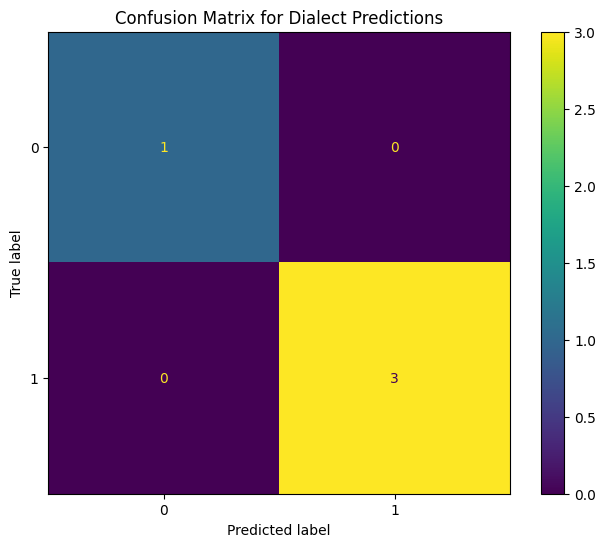

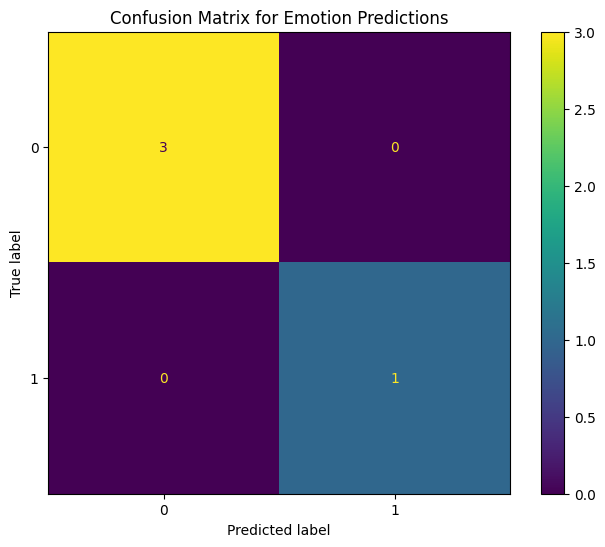

In [ ]:
# رسم البياني للارتباك للهجات
cm_dialect = confusion_matrix(dialect_results, dialect_results)  # استبدل بالقيم الحقيقية إذا كانت متاحة
cmd_dialect = ConfusionMatrixDisplay(confusion_matrix=cm_dialect)
fig, ax = plt.subplots(figsize=(8, 6))
cmd_dialect.plot(ax=ax, values_format='')
ax.set_title("Confusion Matrix for Dialect Predictions")
plt.show()

# رسم البياني للارتباك للإيموشن
cm_emotion = confusion_matrix(emotion_results, emotion_results)  # استبدل بالقيم الحقيقية إذا كانت متاحة
cmd_emotion = ConfusionMatrixDisplay(confusion_matrix=cm_emotion)
fig, ax = plt.subplots(figsize=(8, 6))
cmd_emotion.plot(ax=ax, values_format='')
ax.set_title("Confusion Matrix for Emotion Predictions")
plt.show()

In [ ]:
egy = [
    "مرحبا 🇸🇦 كيف حالش",
    "شلونش",
    " اليوم انا مرا مبسووطةه",
    "تحياتي لكم جميعًا 🌍🇪🇬 في مصر الجميلة",
    "حلو",
    "Hello"]

# استدعاء الدالة
input_text(egy)

Input: مرحبا 🇸🇦 كيف حالش
Dialect Prediction: S with score 1.00
Emotion Prediction: Neutral with score 1.00
--------------------------------------------------
Input: شلونش
Dialect Prediction: S with score 1.00
Emotion Prediction: Neutral with score 0.98
--------------------------------------------------
Input:  اليوم انا مرا مبسووطةه
Dialect Prediction: H with score 1.00
Emotion Prediction: happiness with score 1.00
--------------------------------------------------
Input: تحياتي لكم جميعًا 🌍🇪🇬 في مصر الجميلة
Dialect Prediction: H with score 1.00
Emotion Prediction: happiness with score 1.00
--------------------------------------------------
Input: حلو
Dialect Prediction: W with score 1.00
Emotion Prediction: happiness with score 1.00
--------------------------------------------------
Input: Hello
Dialect Prediction: H with score 1.00
Emotion Prediction: Neutral with score 0.94
--------------------------------------------------


(['S', 'S', 'H', 'H', 'W', 'H'],
 ['Neutral', 'Neutral', 'happiness', 'happiness', 'happiness', 'Neutral'])

In [ ]:
egy2 =["Hello world","Hello world","Hello world"]
OldLength = len(egy2)
